In [23]:
import os
import re
import csv
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import pydicom as dicom
from pathlib import Path
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import sem, t

# Image data

Processed 13 TIFF images.
Image shape: (256, 512)
Processed 100 CT images.
Image shape: (512, 512)


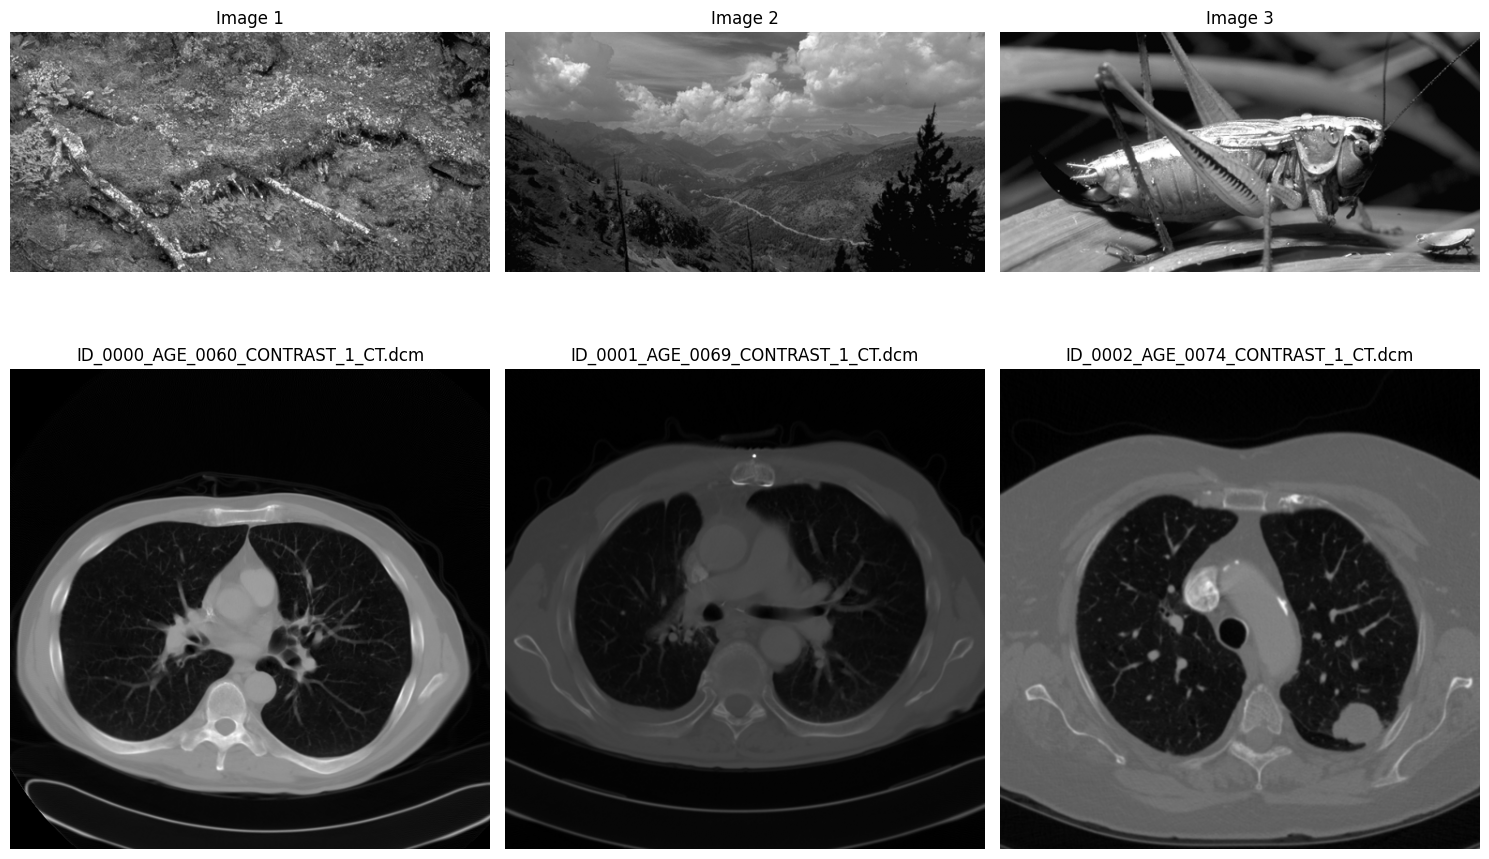

In [24]:
# Process images
imgs_dir = 'images_clean'
imgs = []

# Load .tiff files
for filename in os.listdir(imgs_dir):
    if filename.endswith('.tiff'):
        img = Image.open(os.path.join(imgs_dir, filename))
        img_matrix = np.array(img)
        imgs.append(img_matrix)

print(f"Processed {len(imgs)} TIFF images.")
print(f"Image shape: {imgs[0].shape}")


# Process DICOM CT images
ct_dir = 'ct_imgs'
dicom_paths = [Path(ct_dir) / f for f in os.listdir(ct_dir) if f.endswith('.dcm')]

tags_list = []
imgs_ct = []

# Iterate through each DICOM file
for path in dicom_paths:
    dcm = dicom.dcmread(path, force=True)
    tags = {}

    # Valid image check
    if hasattr(dcm, "SliceLocation") and dcm.SliceLocation:
        if "LOCALIZER" not in dcm.ImageType:
            # Get attributes
            tags = {
                "Filename": path.name,
                "Patient Name": getattr(dcm, "PatientName", "N/A"),
                "Series Description": getattr(dcm, "SeriesDescription", "N/A"),
                "Image Type": "/".join(dcm.ImageType) if hasattr(dcm, "ImageType") else "N/A",
                "Slice Location": getattr(dcm, "SliceLocation", "N/A"),
                "X-Ray Tube Current": getattr(dcm, "XRayTubeCurrent", "N/A"),
                "Instance Number": getattr(dcm, "InstanceNumber", "N/A"),
                "Pixel Spacing": list(dcm.PixelSpacing) if hasattr(dcm, "PixelSpacing") else "N/A",
                "Rows": getattr(dcm, "Rows", "N/A"),
                "Columns": getattr(dcm, "Columns", "N/A"),
                "Image Orientation Patient": list(dcm.ImageOrientationPatient) if hasattr(dcm, "ImageOrientationPatient") else "N/A",
                "Series Instance UID": str(dcm.SeriesInstanceUID) if hasattr(dcm, "SeriesInstanceUID") else "N/A",
            }
            tags_list.append(tags)
            imgs_ct.append(dcm.pixel_array)

# Create DataFrame
tags_df = pd.DataFrame(tags_list)

# Save to CSV
output_file = 'dicom_metadata.csv'
tags_df.to_csv(output_file, index=False)

print(f"Processed {len(tags_df)} CT images.")
print(f"Image shape: {imgs_ct[0].shape}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot first 3 images from imgs
for i in range(3):
  ax = axes[0, i]
  ax.imshow(imgs[i], cmap="gray")
  ax.set_title(f"Image {i+1}")
  ax.axis("off")

# Plot first 3 images from imgs_ct
for i in range(3):
  ax = axes[1, i]
  ax.imshow(imgs_ct[i], cmap="gray")
  ax.set_title(tags_df.loc[i, "Filename"])
  ax.axis("off")

plt.tight_layout()
plt.show()

# Text data

In [25]:
# Process text data
directories = [
    'texts/texts/alt.atheism',
    'texts/texts/sci.crypt',
    'texts/texts/sci.med',
    'texts/texts/soc.religion.christian'
]

all_files = []
for data_dir in directories:
    all_files.extend([os.path.join(data_dir, filename) for filename in os.listdir(data_dir)])

# Randomly sample N files
N = 2262
sampled_files = random.sample(all_files, min(N, len(all_files)))
print(f"Number of sampled files: {len(sampled_files)}")

def preprocess_text(text):
    # Remove email addresses, etc.
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\W+', ' ', text)
    text = text.lower()
    return text.strip()

preprocessed_docs = []
for filepath in sampled_files:
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
        clean_text = preprocess_text(text)
        if clean_text:
            preprocessed_docs.append(clean_text)

print(f"Total preprocessed documents (Text): {len(preprocessed_docs)}")

# Convert to TF-IDF Matrix and Normalize
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(preprocessed_docs)

text_data = tfidf_matrix.toarray()
text_data = normalize(text_data)
print("Text Data shape:", text_data.shape)



# Process DICOM CT text data
df = pd.read_csv('dicom_metadata.csv')

# Combine textual columns
textual_cols = ['Patient Name', 'Series Description', 'Image Type']
df['combined_text'] = df[textual_cols].fillna('').apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

df['cleaned_text'] = df['combined_text'].apply(preprocess_text)

preprocessed_ct_docs = df['cleaned_text'].tolist()
preprocessed_ct_docs = [doc for doc in preprocessed_ct_docs if doc]

print(f"Total preprocessed documents (CT Text): {len(preprocessed_ct_docs)}")

# Convert to TF-IDF Matrix and Normalize
vectorizer_ct = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix_ct = vectorizer_ct.fit_transform(preprocessed_ct_docs)

text_data_ct = normalize(tfidf_matrix_ct.toarray())

print("CT Text Data shape:", text_data_ct.shape)

Number of sampled files: 2262
Total preprocessed documents (Text): 2262
Text Data shape: (2262, 5000)
Total preprocessed documents (CT Text): 100
CT Text Data shape: (100, 115)


# Numeric data (other)

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Process numeric data
numeric_cols = ['Slice Location', 'X-Ray Tube Current', 'Instance Number', 'Rows', 'Columns']
numeric_data = df[numeric_cols].dropna().values
print("Numeric Data shape:", numeric_data.shape)

# Normalize using Min-Max Scaler
scaler = MinMaxScaler()
numeric_data = scaler.fit_transform(numeric_data)

Numeric Data shape: (100, 5)


## Principal Component Analysis (PCA) - Arvid

In [27]:
def PCA(img, number_of_components):
    """
    Principal Component Analysis (PCA) for images.
    """
    img_centered = img

    # Compute covariance matrix
    n_samples = img_centered.shape[0]
    cov_matrix = (img_centered.T @ img_centered) / (n_samples - 1)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Get top k eigenvectors
    top_eigenvectors = eigenvectors[:, :number_of_components]

    # Project onto top k principal components
    img_pca = img_centered @ top_eigenvectors
    return img_pca
    


def PCA_SVD(X, n_components=None):
    """
    Principal Component Analysis (PCA) with Singular Value Decomposition (SVD) for text and numeric data.
    """

    # SVD of X
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    
    # Get top n_components
    if n_components is not None:
        Vt = Vt[:n_components]
    
    # Project onto principal components
    transformed_data = X @ Vt.T
    
    # Compute explained variance
    explained_variance = (S ** 2) / (X.shape[0] - 1)
    
    if n_components is not None:
        explained_variance = explained_variance[:n_components]
    
    return transformed_data, Vt.T, explained_variance


## Random Projection (RP) - Gustav

In [28]:
def RP(img, k):
    """
    Dense Random Projection (RP).
    """
    d = img.shape[1]
    R = np.random.normal(0, 1.0 / np.sqrt(k), size=(k, d))
    img_reduced = img @ R.T
    return img_reduced

## Sparse Random Projection (SRP) - Gustav

In [29]:
def SRP(data, k, density=None):
    """
    Sparse Random Projection (SRP).
    """
    n_samples, d = data.shape
    if density is None:
        density = 1 / np.sqrt(d)
    s = 1 / density

    # Generate random projection matrix
    R = np.zeros((k, d))
    for i in range(k):
        # Number of non-zero entries
        n_nonzero = max(1, int(density * d))

        # Get random non-zero entries
        indices = np.random.choice(d, n_nonzero, replace=False)
        values = np.random.choice([np.sqrt(s) / np.sqrt(k), -np.sqrt(s) / np.sqrt(k)], size=n_nonzero)

        R[i, indices] = values

    # Convert to sparse matrix if necessary
    R_sparse = sp.csr_matrix(R)

    # Project onto random subspace
    data_reduced = data @ R_sparse.T

    return data_reduced

## Discrete Cosine Transform (DCT) - Matei

#### Notes
Breaks data into patterns, keeps important trends and ignores noise. Used for simplifying or compressing data, more often in image or audio processing as text doesn't have the same wave-like patterns

[Formula and logic](https://www.mathworks.com/help/images/ref/dct2.html)


$DCT(u, v) = \alpha(u)\alpha(v) \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cos\left[\frac{\pi u (2x+1)}{2M}\right] \cos\left[\frac{\pi v (2y+1)}{2N}\right]$


**dct_1d():**
$
X_k = \alpha(k) \sum_{n=0}^{N-1} x_n \cos\left(\frac{\pi k (2n + 1)}{2N}\right)
$

**idct_1d():**
$
x_n = \sum_{k=0}^{N-1} \alpha(k) X_k \cos\left(\frac{\pi k (2n + 1)}{2N}\right)
$

$
DCT_{2D}(u,v) = DCT_\text{rows} \rightarrow DCT_\text{cols}
$

In [30]:
def DCT(data, k):
    """
    Discrete Cosine Transform (DCT) compression.
    """
    N = data.shape[1]
    k_indices = np.arange(N).reshape(N, 1)
    n_indices = (2 * np.arange(N) + 1) / (2 * N)
    cos_terms = np.cos(np.pi * k_indices @ n_indices.reshape(1, -1))
    scale = np.sqrt(2 / N) * np.ones(N)
    scale[0] = np.sqrt(1 / N)
    dct_matrix = scale[:, None] * cos_terms

    dct_transformed = data @ dct_matrix.T
    dct_compressed = dct_transformed[:, :k]
    return dct_compressed

## Comparing algorithms

In [31]:
def get_img_window(img, window_size=(50, 50)):
    """
    Get one randomly selected window of given size from image.
    """
    max_x = img.shape[0] - window_size[0]
    max_y = img.shape[1] - window_size[1]
    x_start = np.random.randint(0, max_x)
    y_start = np.random.randint(0, max_y)
    return img[x_start:x_start + window_size[0], y_start:y_start + window_size[1]]

def get_windows(imgs, num_windows=1000, window_size=(50, 50)):
    """
    Get specified number of random windows from list of 1D flattened images.
    """
    windows = []
    for _ in range(num_windows):
        img = imgs[np.random.randint(0, len(imgs))]
        window = get_img_window(img, window_size)
        windows.append(window.flatten())
    return np.array(windows)

def get_distortion_error(data0, data1, num_pairs=100, conf=0.95):
    """
    Compute relative distortion error for pairwise distances with confidence intervals.
    """
    n = data0.shape[0]
    errors = []
    pairs = random.sample(range(n), num_pairs * 2)
    for i in range(0, len(pairs), 2):
        idx1, idx2 = pairs[i], pairs[i + 1]
        dist0 = np.linalg.norm(data0[idx1] - data0[idx2])
        dist1 = np.linalg.norm(data1[idx1] - data1[idx2])
        if dist0 > 1e-10:
            relative_error = (dist1 - dist0) / dist0
            errors.append(relative_error)

    errors = np.array(errors)
    mean_error = np.mean(errors)
    std_error = sem(errors)
    h = std_error * t.ppf((1 + conf) / 2, df=len(errors) - 1)
    return mean_error, h


def get_distortion_error_dot(data0, data1, num_pairs=1000, conf=0.95):
    """
    Compute Relative Distortion error for pairwise dot products with confidence intervals.
    """
    n = data0.shape[0]
    if num_pairs * 2 > n:
        num_pairs = n // 2

    errors = []
    pairs = random.sample(range(n), num_pairs * 2)
    for i in range(0, len(pairs), 2):
        idx1, idx2 = pairs[i], pairs[i + 1]
        dot0 = np.dot(data0[idx1], data0[idx2])
        dot1 = np.dot(data1[idx1], data1[idx2])
        if abs(dot0) > 1e-10:
            relative_error = (dot1 - dot0) / dot0
            errors.append(relative_error)

    errors = np.array(errors)
    mean_error = np.mean(errors)
    std_error = sem(errors)
    h = std_error * t.ppf((1 + conf) / 2, df=len(errors) - 1)
    return mean_error, h

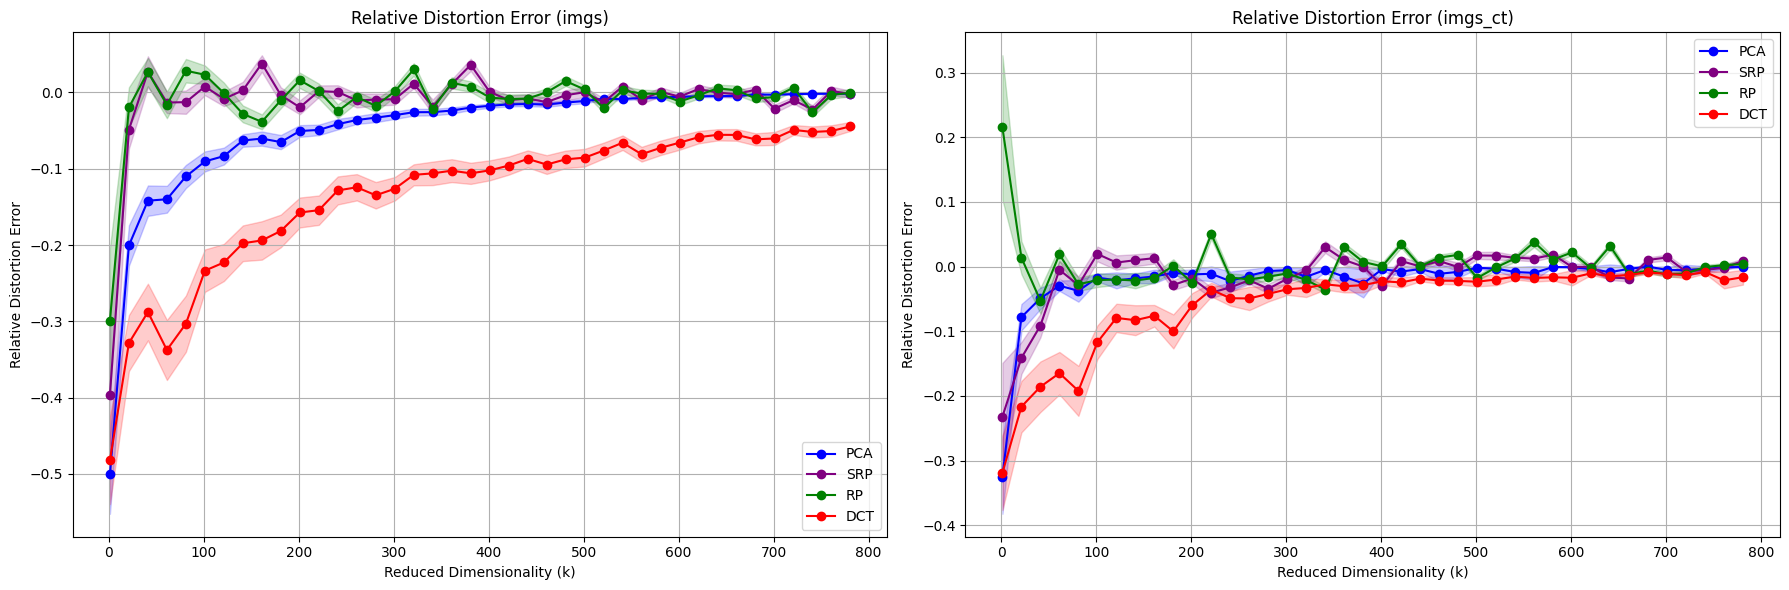

In [32]:
### Image Data Errors


# Extract image windows
windows_imgs = get_windows(imgs, num_windows=1000)
windows_ct = get_windows(imgs_ct, num_windows=1000)

# Normalize
scaler = StandardScaler()
windows_imgs = scaler.fit_transform(windows_imgs)
windows_ct = scaler.fit_transform(windows_ct)

reduced_dims = np.arange(1, 800, 20)

errors_imgs = {"PCA": [], "RP": [], "SRP": [], "DCT": []}
cis_imgs = {"PCA": [], "RP": [], "SRP": [], "DCT": []}
errors_ct = {"PCA": [], "RP": [], "SRP": [], "DCT": []}
cis_ct = {"PCA": [], "RP": [], "SRP": [], "DCT": []}

# Compute relative distortion error
for k in reduced_dims:
    # PCA
    reduced_pca_imgs = PCA(windows_imgs, k)
    reduced_pca_ct = PCA(windows_ct, k)
    
    mean_error, ci = get_distortion_error(windows_imgs, reduced_pca_imgs)
    errors_imgs["PCA"].append(mean_error)
    cis_imgs["PCA"].append(ci)
    
    mean_error_ct, ci_ct = get_distortion_error(windows_ct, reduced_pca_ct)
    errors_ct["PCA"].append(mean_error_ct)
    cis_ct["PCA"].append(ci_ct)
    
    # Dense RP
    reduced_rp_imgs = RP(windows_imgs, k)
    reduced_rp_ct = RP(windows_ct, k)
    
    mean_error, ci = get_distortion_error(windows_imgs, reduced_rp_imgs)
    errors_imgs["RP"].append(mean_error)
    cis_imgs["RP"].append(ci)
    
    mean_error_ct, ci_ct = get_distortion_error(windows_ct, reduced_rp_ct)
    errors_ct["RP"].append(mean_error_ct)
    cis_ct["RP"].append(ci_ct)

    # Sparse RP
    reduced_srp_imgs = SRP(windows_imgs, k)
    reduced_srp_ct = SRP(windows_ct, k)
    
    mean_error, ci = get_distortion_error(windows_imgs, reduced_srp_imgs)
    errors_imgs["SRP"].append(mean_error)
    cis_imgs["SRP"].append(ci)
    
    mean_error_ct, ci_ct = get_distortion_error(windows_ct, reduced_srp_ct)
    errors_ct["SRP"].append(mean_error_ct)
    cis_ct["SRP"].append(ci_ct)

    # DCT
    reduced_dct_imgs = DCT(windows_imgs, k)
    reduced_dct_ct = DCT(windows_ct, k)
    
    mean_error, ci = get_distortion_error(windows_imgs, reduced_dct_imgs)
    errors_imgs["DCT"].append(mean_error)
    cis_imgs["DCT"].append(ci)
    
    mean_error_ct, ci_ct = get_distortion_error(windows_ct, reduced_dct_ct)
    errors_ct["DCT"].append(mean_error_ct)
    cis_ct["DCT"].append(ci_ct)


# Plot results
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

def plot_errors(ax, x, y, ci, label, color):
    ax.plot(x, y, label=label, marker='o', color=color)
    ax.fill_between(x, np.array(y) - np.array(ci), np.array(y) + np.array(ci), color=color, alpha=0.2)

colors = {"PCA": "blue", "RP": "green", "SRP": "purple", "DCT": "red"}

# Plot imgs
for method, color in colors.items():
    plot_errors(axes[0], reduced_dims, errors_imgs[method], cis_imgs[method], label=method, color=color)
axes[0].set_title("Relative Distortion Error (imgs)")
axes[0].set_xlabel("Reduced Dimensionality (k)")
axes[0].set_ylabel("Relative Distortion Error")
axes[0].legend()
axes[0].grid(True)


# Plot imgs_ct
for method, color in colors.items():
    plot_errors(axes[1], reduced_dims, errors_ct[method], cis_ct[method], label=method, color=color)
axes[1].set_title("Relative Distortion Error (imgs_ct)")
axes[1].set_xlabel("Reduced Dimensionality (k)")
axes[1].set_ylabel("Relative Distortion Error")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

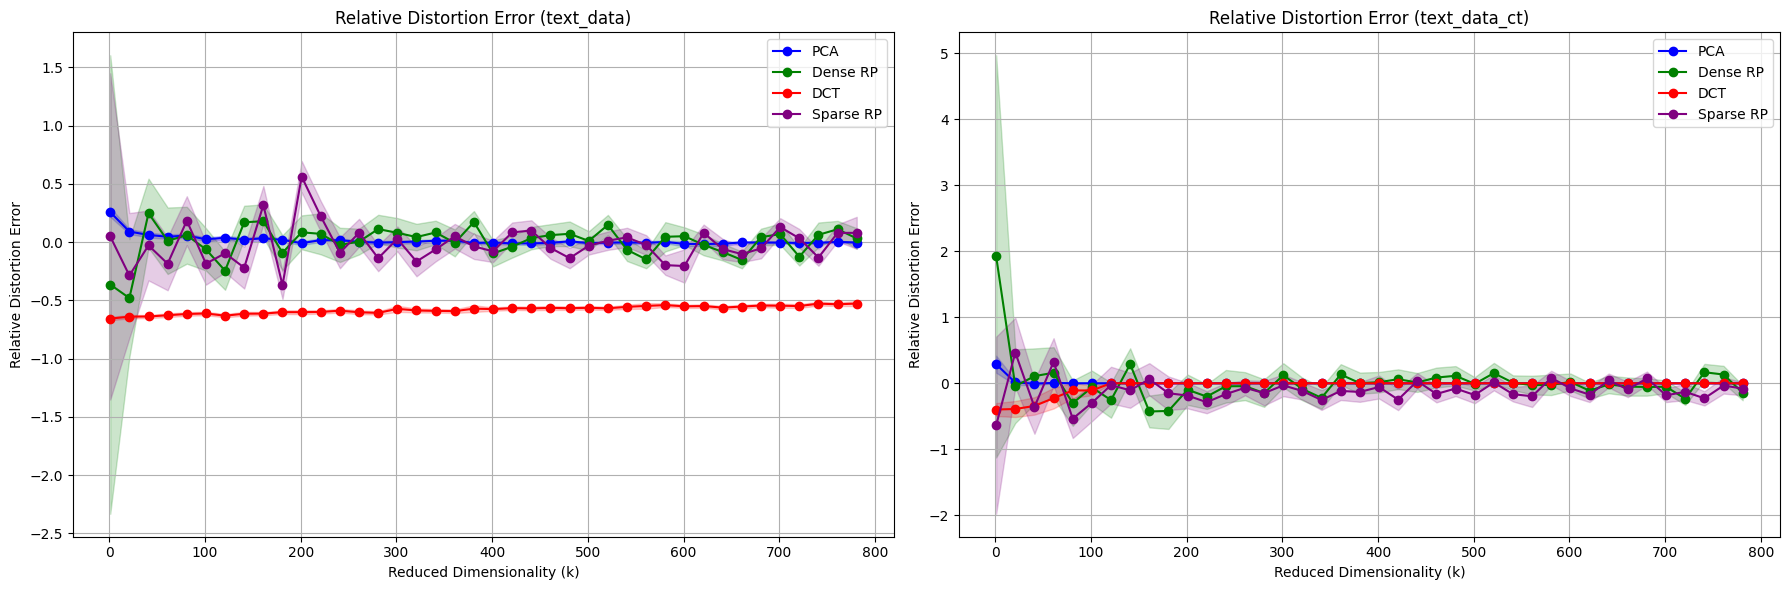

In [33]:
### Text Data Errors


reduced_dims = np.arange(1, 800, 20)

errors_text = {"PCA": [], "RP": [], "SRP": [], "DCT": []}
cis_text = {"PCA": [], "RP": [], "SRP": [], "DCT": []}
errors_text_ct = {"PCA": [], "RP": [], "SRP": [], "DCT": []}
cis_text_ct = {"PCA": [], "RP": [], "SRP": [], "DCT": []}

# Compute relative distortion error
for k in reduced_dims:
    # PCA
    reduced_pca_text, _, _ = PCA_SVD(text_data, k)
    reduced_pca_text_ct, _, _ = PCA_SVD(text_data_ct, k)
    
    mean_error, ci = get_distortion_error_dot(text_data, reduced_pca_text)
    errors_text["PCA"].append(mean_error)
    cis_text["PCA"].append(ci)
    
    mean_error_ct, ci_ct = get_distortion_error_dot(text_data_ct, reduced_pca_text_ct)
    errors_text_ct["PCA"].append(mean_error_ct)
    cis_text_ct["PCA"].append(ci_ct)

    # Dense Random Projection
    reduced_rp_text = RP(text_data, k)
    reduced_rp_text_ct = RP(text_data_ct, k)

    mean_error, ci = get_distortion_error_dot(text_data, reduced_rp_text)
    errors_text["RP"].append(mean_error)
    cis_text["RP"].append(ci)

    mean_error_ct, ci_ct = get_distortion_error_dot(text_data_ct, reduced_rp_text_ct)
    errors_text_ct["RP"].append(mean_error_ct)
    cis_text_ct["RP"].append(ci_ct)

    # Sparse Random Projection
    reduced_srp_text = SRP(text_data, k)
    reduced_srp_text_ct = SRP(text_data_ct, k)
    
    mean_error, ci = get_distortion_error_dot(text_data, reduced_srp_text)
    errors_text["SRP"].append(mean_error)
    cis_text["SRP"].append(ci)

    mean_error_ct, ci_ct = get_distortion_error_dot(text_data_ct, reduced_srp_text_ct)
    errors_text_ct["SRP"].append(mean_error_ct)
    cis_text_ct["SRP"].append(ci_ct)

    # DCT
    reduced_dct_text = DCT(text_data, k)
    reduced_dct_text_ct = DCT(text_data_ct, k)

    mean_error, ci = get_distortion_error_dot(text_data, reduced_dct_text)
    errors_text["DCT"].append(mean_error)
    cis_text["DCT"].append(ci)
    
    mean_error_ct, ci_ct = get_distortion_error_dot(text_data_ct, reduced_dct_text_ct)
    errors_text_ct["DCT"].append(mean_error_ct)
    cis_text_ct["DCT"].append(ci_ct)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

def plot_errors(ax, x, y, ci, label, color):
    ax.plot(x, y, label=label, marker='o', color=color)
    ax.fill_between(x, np.array(y) - np.array(ci), np.array(y) + np.array(ci), color=color, alpha=0.2)

colors = {"PCA": "blue", "RP": "green", "SRP": "purple", "DCT": "red"}

# Plot text_data
for method, color in colors.items():
    plot_errors(axes[0], reduced_dims, errors_text[method], cis_text[method], label=method, color=color)
axes[0].set_title("Relative Distortion Error (text_data)")
axes[0].set_xlabel("Reduced Dimensionality (k)")
axes[0].set_ylabel("Relative Distortion Error")
axes[0].legend()
axes[0].grid(True)

# Plot text_data_ct
for method, color in colors.items():
    plot_errors(axes[1], reduced_dims, errors_text_ct[method], cis_text_ct[method], label=method, color=color)
axes[1].set_title("Relative Distortion Error (text_data_ct)")
axes[1].set_xlabel("Reduced Dimensionality (k)")
axes[1].set_ylabel("Relative Distortion Error")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

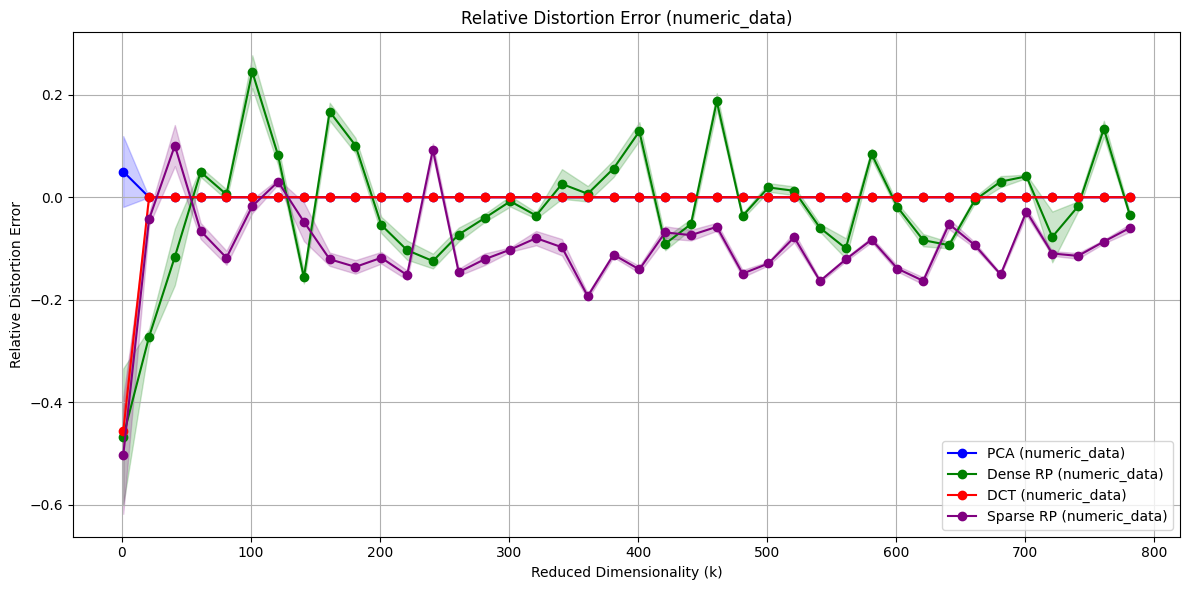

In [34]:
### Numeric Data Errors


reduced_dims = np.arange(1, 800, 20)

errors_numeric = {"PCA": [], "RP": [], "SRP": [], "DCT": []}
cis_numeric = {"PCA": [], "RP": [], "SRP": [], "DCT": []}

# Compute relative distortion error
for k in reduced_dims:
    # PCA
    reduced_pca_numeric, _, _ = PCA_SVD(numeric_data, k)
    mean_error, ci = get_distortion_error_dot(numeric_data, reduced_pca_numeric)
    errors_numeric["PCA"].append(mean_error)
    cis_numeric["PCA"].append(ci)

    # Dense Random Projection
    reduced_rp_numeric = RP(numeric_data, k)
    mean_error, ci = get_distortion_error_dot(numeric_data, reduced_rp_numeric)
    errors_numeric["RP"].append(mean_error)
    cis_numeric["RP"].append(ci)

    # Sparse Random Projection
    reduced_srp_numeric = SRP(numeric_data, k)
    mean_error, ci = get_distortion_error_dot(numeric_data, reduced_srp_numeric)
    errors_numeric["SRP"].append(mean_error) 
    cis_numeric["SRP"].append(ci)

    # DCT
    reduced_dct_numeric = DCT(numeric_data, k)
    mean_error, ci = get_distortion_error_dot(numeric_data, reduced_dct_numeric)
    errors_numeric["DCT"].append(mean_error)
    cis_numeric["DCT"].append(ci)

# Plot results
fig, ax = plt.subplots(figsize=(12, 6))

def plot_errors(ax, x, y, ci, label, color):
    ax.plot(x, y, label=label, marker='o', color=color)
    ax.fill_between(x, np.array(y) - np.array(ci), np.array(y) + np.array(ci), color=color, alpha=0.2)

colors = {"PCA": "blue", "RP": "green", "SRP": "purple", "DCT": "red" }

# Plot numeric_data 
for method, color in colors.items():
    plot_errors(ax, reduced_dims, errors_numeric[method], cis_numeric[method], label=f"{method} (numeric_data)", color=color)
ax.set_title("Relative Distortion Error (numeric_data)")
ax.set_xlabel("Reduced Dimensionality (k)")
ax.set_ylabel("Relative Distortion Error")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

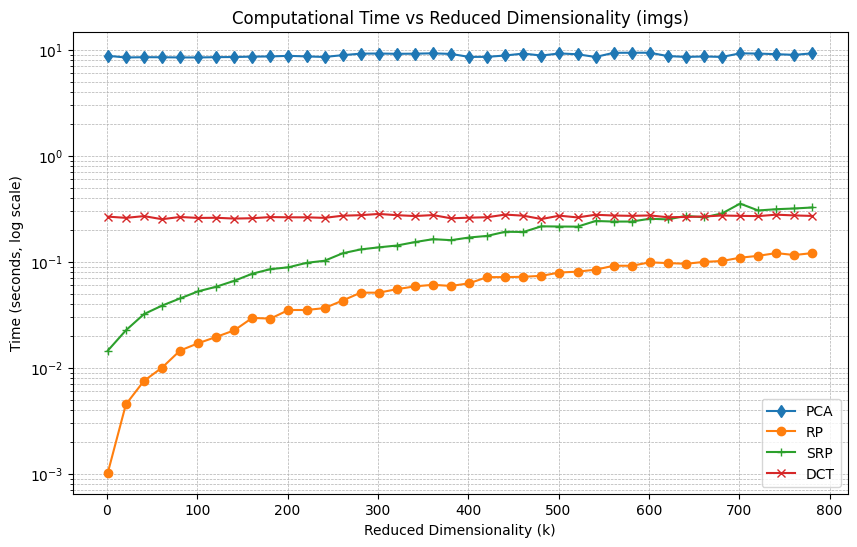

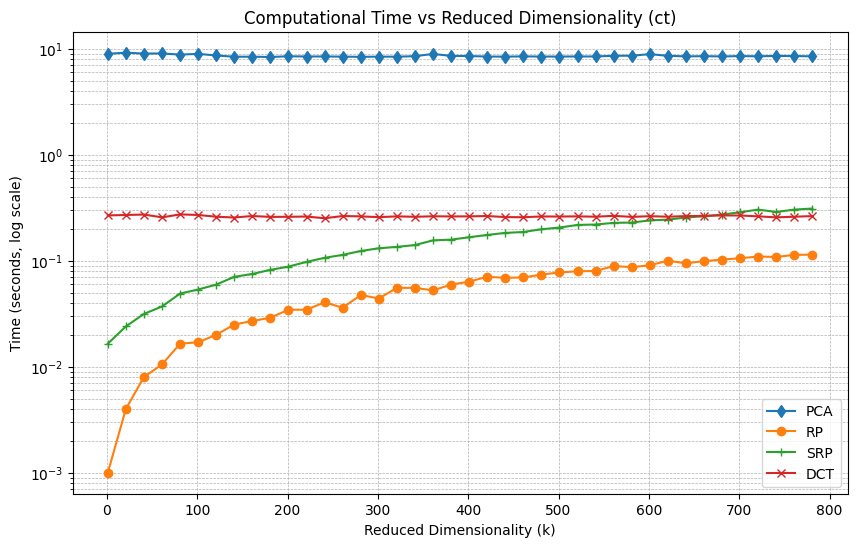

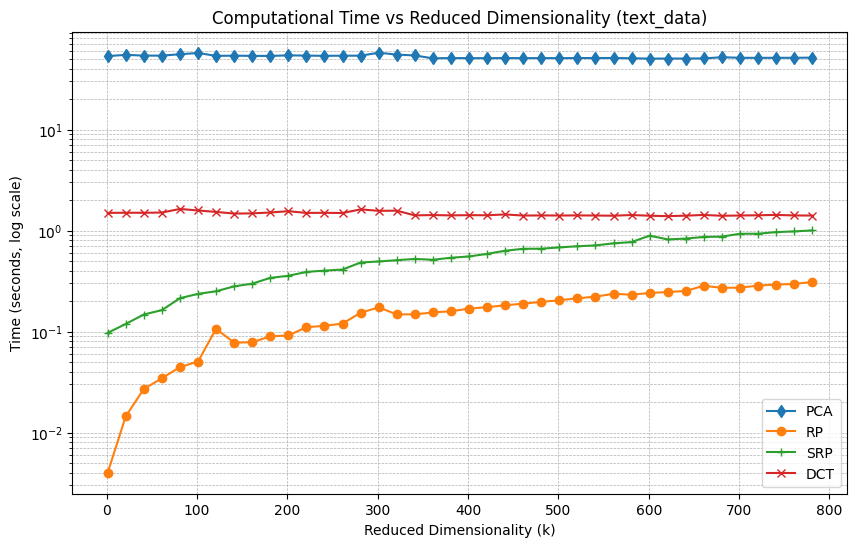

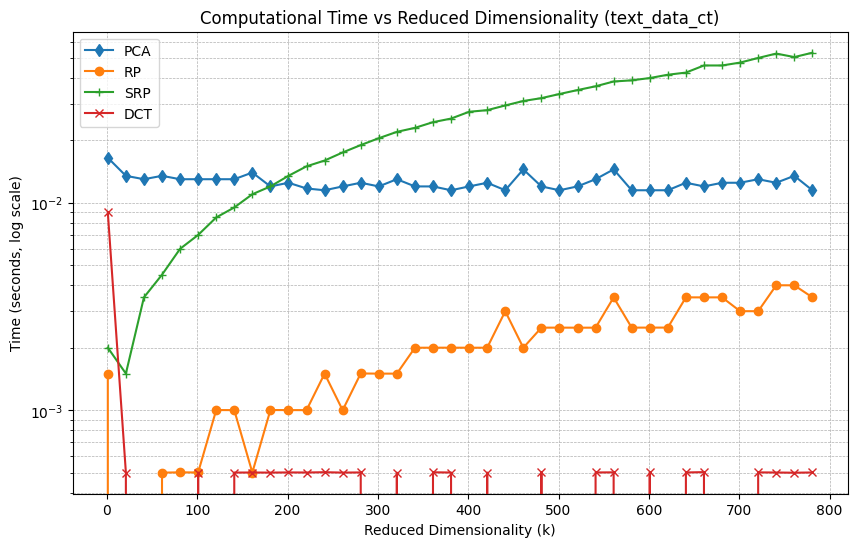

In [36]:
timing_results = {
    "imgs": {"PCA": [], "RP": [], "SRP": [], "DCT": []},
    "ct": {"PCA": [], "RP": [], "SRP": [], "DCT": []},
    "text_data": {"PCA": [], "RP": [], "SRP": [], "DCT": []},
    "text_data_ct": {"PCA": [], "RP": [], "SRP": [], "DCT": []}
}

datasets = {
    "imgs": windows_imgs,
    "ct": windows_ct,
    "text_data": text_data,
    "text_data_ct": text_data_ct
}

# Measure timings
for dataset, data in datasets.items():
    for k in reduced_dims:
        # PCA
        start_time = time.time()
        reduced_pca = PCA(data, k)
        timing_results[dataset]["PCA"].append(time.time() - start_time)

        # Dense Random Projection
        start_time = time.time()
        reduced_rp = RP(data, k)
        timing_results[dataset]["RP"].append(time.time() - start_time)

        # Sparse Random Projection
        start_time = time.time()
        reduced_srp = SRP(data, k, density=0.1)
        timing_results[dataset]["SRP"].append(time.time() - start_time)

        # DCT
        start_time = time.time()
        reduced_dct = DCT(data, k)
        timing_results[dataset]["DCT"].append(time.time() - start_time)

# Plot computational time
for dataset, timings in timing_results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(reduced_dims, timings["PCA"], 'd-', label='PCA')
    plt.plot(reduced_dims, timings["RP"], 'o-', label='RP')
    plt.plot(reduced_dims, timings["SRP"], '+-', label='SRP')
    plt.plot(reduced_dims, timings["DCT"], 'x-', label='DCT')
    plt.yscale('log')
    plt.title(f"Computational Time vs Reduced Dimensionality ({dataset})")
    plt.xlabel("Reduced Dimensionality (k)")
    plt.ylabel("Time (seconds, log scale)")
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()